In [ ]:
# IMPORT DATASET

In [ ]:
import pandas as pd
energy = '/content/energy_dataset.xlsx'
weather = '/content/weather_features.xlsx'

energy_df = pd.read_excel(energy)
weather_df = pd.read_excel(weather)

In [ ]:
# AGGREGATION

In [ ]:
weather_df = weather_df.groupby('dt_iso').agg({
    'temp':'mean',
    'temp_min':'mean',
    'temp_max':'mean',
    'humidity':'mean',
    'wind_speed':'mean',
    'pressure':'mean',
    'rain_1h':'mean',
    'rain_3h':'mean',
    'snow_3h':'mean',
    'clouds_all':'mean',
    'wind_deg':'mean',
    'weather_id':lambda x: x.mode()[0] if not x.empty else None,
    'weather_main':lambda x: x.mode()[0] if not x.empty else None, # Use a lambda function to apply mode to each group
    'weather_description':lambda x: x.mode()[0] if not x.empty else None, # Use a lambda function to apply mode to each group
    'weather_icon':lambda x: x.mode()[0] if not x.empty else None # Use a lambda function to apply mode to each group
}).reset_index()

In [ ]:
# MERGING THE DATASET

In [ ]:
df = pd.merge(energy_df, weather_df, left_on='dt_iso', right_on='dt_iso')
df.drop(columns=['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation wind offshore', 'forecast wind offshore eday ahead', 'generation marine', 'generation hydro pumped storage aggregated'],inplace=True)

In [ ]:
# FILL THE MISSING VALUES

df_ffill = df.fillna(method='ffill',inplace=True)

In [ ]:
df.isnull().sum()

dt_iso                                         0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual        

In [ ]:
# GENERATING FEATURES

In [ ]:
df['dt_iso'] = pd.to_datetime(df['dt_iso'], utc=True) #Handle timezone information
df['date'] = df['dt_iso'].dt.date
df['time'] = df['dt_iso'].dt.time

In [ ]:
df['weekday'] = df['dt_iso'].dt.weekday #number format of weekday; 0 refers to Monday
df['month'] = df['dt_iso'].dt.month
df['year'] = df['dt_iso'].dt.year
df['hour'] = df['dt_iso'].dt.hour

In [ ]:
df['day_of_week_name'] = df['dt_iso'].dt.strftime('%A')  # %A for full weekday name

In [ ]:
for i in range(len(df)):
    # Access the datetime object directly from the 'dt_iso' column
    dt_iso_value = df.loc[i, 'dt_iso']
    hour = dt_iso_value.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df.loc[i, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df.loc[i, 'business hour'] = 1
    else:
        df.loc[i, 'business hour'] = 0

In [ ]:
df = df.set_index('dt_iso')  # Set 'dt_iso' as index

for i in range(len(df)):
    position = df.index[i]
    weekday = position.weekday()  # position variable accesses the weekday column of the record
    if (weekday == 6):
        df.loc[position, 'weekday'] = 2 #Sunday
    elif (weekday == 5):
        df.loc[position, 'weekday'] = 1 #Saturday
    else:
        df.loc[position, 'weekday'] = 0

In [ ]:
df['generation coal all'] = df['generation fossil hard coal'] + df['generation fossil brown coal/lignite']

In [ ]:
# VISUALIZATION

<Axes: xlabel='day_of_week_name'>

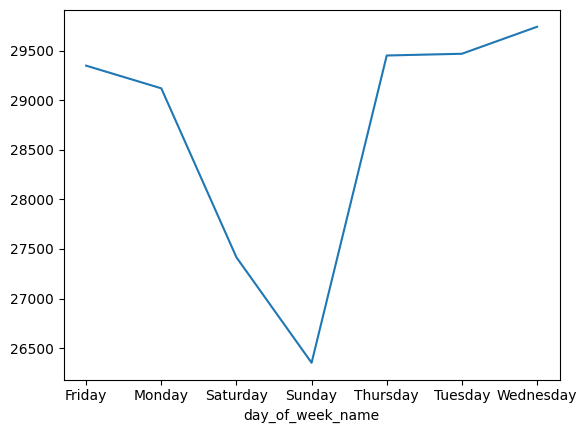

In [ ]:
df1 = df.groupby('day_of_week_name')['total load actual'].mean()
df1.reset_index()
df1.plot(kind='line', x='day_of_week_name', y='total load actual')
#plot does not take the values of weekdays as categorical data

<Axes: xlabel='month'>

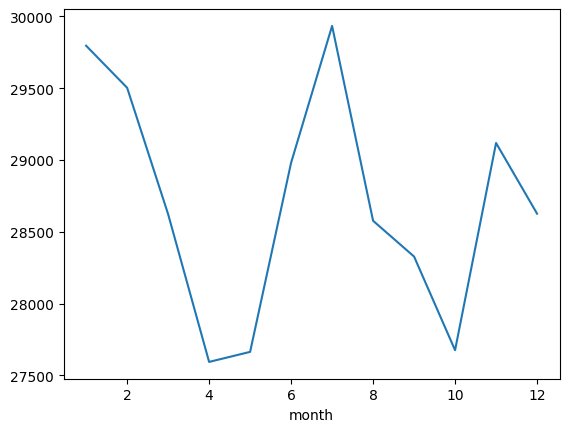

In [ ]:
df2 = df.groupby('month')['total load actual'].mean()
df2.reset_index()
df2.plot(kind='line', x='month', y='total load actual')

<Axes: xlabel='year'>

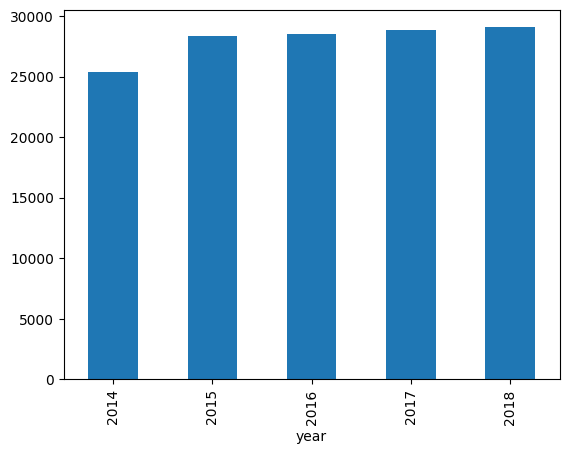

In [ ]:
df3 = df.groupby('year')['total load actual'].mean()
df3.reset_index()
df3.plot(kind='bar', x='year', y='total load actual')

In [ ]:
# CORRELATION MATRIX

In [ ]:
correlation_matrix = df[['price actual','year','temp', 'wind_speed', 'pressure', 'humidity', 'clouds_all', 'total load actual']].corr()

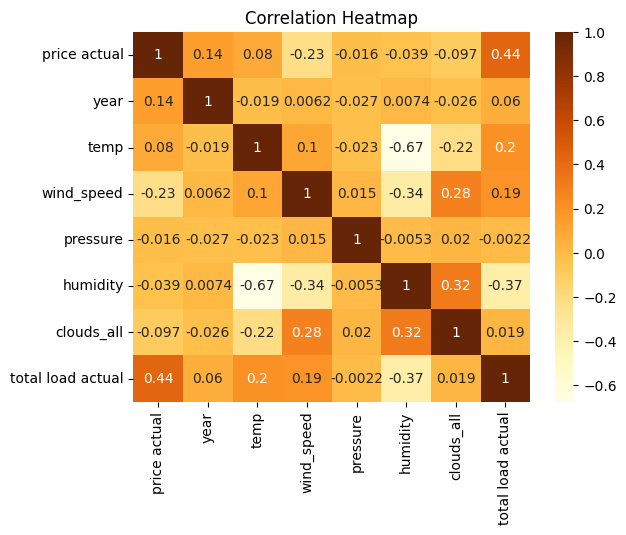

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr')
plt.title("Correlation Heatmap")
plt.show()

<Axes: xlabel='hour'>

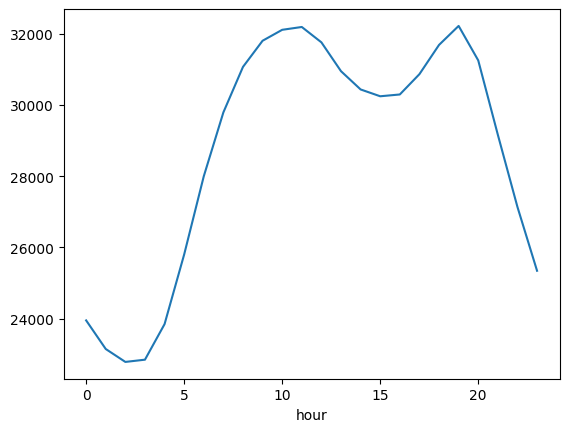

In [ ]:
df4=df.groupby('hour')['total load actual'].mean()
df4.plot(kind='line', x='hour', y='total load actual')

In [ ]:
# PREPROCESSING

In [ ]:
from sklearn.preprocessing import OneHotEncoder
oht=OneHotEncoder()
data = oht.fit_transform(df[['weekday']])
data.shape

(35064, 3)

In [ ]:
# FINDING OUTLIERS AND REMOVE THEM
import scipy.stats as stats
import numpy as np
numerical_cols = df.select_dtypes(include=np.number).columns
z_scores = stats.zscore(df[numerical_cols])
column_names = numerical_cols
outliers = np.where(np.abs(z_scores) > 3) #np.where function returns a tuple where each element is an array of indices where the condition is true along each axis.
outliers_count = {}
# Print the number of outliers for each column
for i in range(z_scores.shape[1]):
    num_outliers = len(outliers[0][outliers[1] == i])  # Count the number of rows for each column. 0 means row index, 1 means column index.
    outliers_count[column_names[i]] = num_outliers
    print(f"Number of outliers in column '{column_names[i]}': {num_outliers}")

Number of outliers in column 'generation biomass': 5
Number of outliers in column 'generation fossil brown coal/lignite': 0
Number of outliers in column 'generation fossil gas': 491
Number of outliers in column 'generation fossil hard coal': 0
Number of outliers in column 'generation fossil oil': 27
Number of outliers in column 'generation hydro pumped storage consumption': 1005
Number of outliers in column 'generation hydro run-of-river and poundage': 0
Number of outliers in column 'generation hydro water reservoir': 194
Number of outliers in column 'generation nuclear': 53
Number of outliers in column 'generation other': 0
Number of outliers in column 'generation other renewable': 7
Number of outliers in column 'generation solar': 0
Number of outliers in column 'generation waste': 106
Number of outliers in column 'generation wind onshore': 113
Number of outliers in column 'forecast solar day ahead': 0
Number of outliers in column 'forecast wind onshore day ahead': 128
Number of outli

In [ ]:
filtered_columns = [column for column, count in outliers_count.items() if count >= 5]
print(len(filtered_columns),filtered_columns)

19 ['generation biomass', 'generation fossil gas', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro water reservoir', 'generation nuclear', 'generation other renewable', 'generation waste', 'generation wind onshore', 'forecast wind onshore day ahead', 'price day ahead', 'price actual', 'wind_speed', 'pressure', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all', 'weather_id']


In [ ]:
z_scores_df = pd.DataFrame(z_scores, columns=numerical_cols)# create a dataframe for z-scores

In [ ]:
# Get the indices of rows that contain outliers
outlier_indices = z_scores_df[(np.abs(z_scores_df) > 3).any(axis=1)].index
len(outlier_indices) #pandas.core.indexes.datetimes.DatetimeIndex

4064

In [ ]:
df.drop(outlier_indices, inplace=True)

In [ ]:
# MODELLING

In [ ]:
# SIMPLE LINEAR REGRESSION FOR PRICE ACTUAL

In [ ]:
# SIMPLE LINEAR REGRESSION FOR TOTAL LOAD ACTUAL

In [ ]:
#Random Forest without tuning for price actual

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Features for predicting price
X_price = df[['temp','humidity','wind_deg','pressure','temp_max','temp_min','rain_1h','rain_3h','clouds_all','snow_3h']]
y_price = df['price actual']

# Split the data
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

# Create and fit the model
rf_model_price = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_price.fit(X_price_train, y_price_train)

# Predict and evaluate
y_pred_price = rf_model_price.predict(X_price_test)

mse_rf = mean_squared_error(y_price_test, y_pred_price)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_price_test, y_pred_price)
mape_rf = mean_absolute_percentage_error(y_price_test, y_pred_price)

# Calculate Adjusted R-squared
n = len(y_price_test)  # number of observations
p = X_price_test.shape[1]  # number of predictors
adjusted_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)

# Print results
print(f'Random Forest Regression - Adjusted R-squared: {adjusted_r2_rf}')
print(f'Random Forest Regression - Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'Random Forest Regression - Mean Squared Error: {mse_rf}')
print(f'Random Forest Regression - R-squared: {r2_rf}')
print(f'Random Forest Regression - Mean Absolute Percentage Error: {mape_rf}')

Random Forest Regression - Adjusted R-squared: 0.31717738889291036
Random Forest Regression - Root Mean Squared Error (RMSE): 10.987877716692635
Random Forest Regression - Mean Squared Error: 120.73345671699056
Random Forest Regression - R-squared: 0.3182788933470272
Random Forest Regression - Mean Absolute Percentage Error: 0.16735411796725122


In [ ]:
# FOR LOAD

In [ ]:
# Features for predicting load
X_Load = df[['rain_3h','clouds_all', 'price actual', 'generation biomass', 'generation hydro pumped storage consumption', 'generation wind onshore', 'generation fossil oil']]
y_Load = df['total load actual']

# Split the data
X_Load_train, X_Load_test, y_Load_train, y_Load_test = train_test_split(X_Load, y_Load, test_size=0.2, random_state=42)

# Create and fit the model
rf_model_Load = RandomForestRegressor(n_estimators=100, random_state=42) # Changed variable name to rf_model_Load
rf_model_Load.fit(X_Load_train, y_Load_train)

# Predict and evaluate
y_pred_Load = rf_model_Load.predict(X_Load_test)
rmse_rf = np.sqrt(mse_rf)
mse_rf = mean_squared_error(y_Load_test, y_pred_Load)
r2_rf = r2_score(y_Load_test, y_pred_Load) # Use y_pred_Load instead of y_pred_price
mape_rf = mean_absolute_percentage_error(y_Load_test, y_pred_Load)

# Calculate Adjusted R-squared
n = len(y_price_test)  # number of observations
p = X_price_test.shape[1]  # number of predictors
adjusted_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)

# Print results
print(f'Random Forest Regression - Adjusted R-squared: {adjusted_r2_rf}')
print(f'Random Forest Regression - Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'Random Forest Regression - Mean Squared Error: {mse_rf}')
print(f'Random Forest Regression - R-squared: {r2_rf}')
print(f'Random Forest Regression - Mean Absolute Percentage Error: {mape_rf}')

Random Forest Regression - Adjusted R-squared: 0.7529827448223851
Random Forest Regression - Root Mean Squared Error (RMSE): 10.987877716692635
Random Forest Regression - Mean Squared Error: 4942637.252765306
Random Forest Regression - R-squared: 0.7533812240209294
Random Forest Regression - Mean Absolute Percentage Error: 0.0598885602079321


In [ ]:
# RANDOM FOREST WITH PARAMETER TUNING FOR PRICE

In [ ]:
# Features for predicting price
X_price = df[['temp', 'humidity', 'wind_deg', 'pressure', 'temp_max', 'temp_min', 'rain_1h', 'rain_3h', 'clouds_all']]
y_price = df['price actual']

In [ ]:
# Define the parameter distribution for RandomizedSearchCV
from random import randint
from scipy.stats import randint as randint
param_dist = {
    'n_estimators': randint(50, 250),             # Number of trees in the forest
    'max_depth': [None] + list(randint(5, 15).rvs(3)),  # Maximum depth of the trees
    'min_samples_split': randint(2, 10),          # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 5),           # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                   # Whether bootstrap samples are used when building trees
}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
rf_model_price = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model_price, param_distributions=param_dist,
                                   n_iter=50, cv=3, scoring='neg_mean_squared_error',
                                   random_state=42, n_jobs=-1, verbose=2)

In [31]:
random_search.fit(X_price_train, y_price_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 14, 12, 11],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x788e9f091c00>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x788e9f092350>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x788e9f091f90>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [32]:
# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

# Evaluate the model with the best parameters on the test set
best_rf_model_price = random_search.best_estimator_
y_pred_price = best_rf_model_price.predict(X_price_test)

# Evaluate and print results
mse_rf = mean_squared_error(y_price_test, y_pred_price)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_price_test, y_pred_price)
mape_rf = mean_absolute_percentage_error(y_price_test, y_pred_price)

# Calculate Adjusted R-squared
n = len(y_price_test)  # number of observations
p = X_price_test.shape[1]  # number of predictors
adjusted_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - p - 1)

print(f'Random Forest Regression - Mean Squared Error: {mse_rf}')
print(f'Random Forest Regression - Adjusted R-squared: {adjusted_r2_rf}')
print(f'Random Forest Regression - Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'Random Forest Regression - R-squared: {r2_rf}')
print(f'Random Forest Regression - Mean Absolute Percentage Error: {mape_rf}')

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 191}
Best score found:  -127.2793510789138
Random Forest Regression - Mean Squared Error: 122.1342271408356
Random Forest Regression - Adjusted R-squared: 0.3092551629881759
Random Forest Regression - Root Mean Squared Error (RMSE): 11.051435523986719
Random Forest Regression - R-squared: 0.31036944728727545
Random Forest Regression - Mean Absolute Percentage Error: 0.16929655257306755


In [ ]:
# FOR LOAD ACTUAL

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import pandas as pd
from scipy.stats import randint


# Features for predicting load
X_Load = df[['temp', 'humidity', 'rain_3h', 'clouds_all', 'price actual',
             'generation biomass', 'generation hydro pumped storage consumption',
             'generation wind onshore', 'generation fossil oil']]
y_Load = df['total load actual']

# Split the data
X_Load_train, X_Load_test, y_Load_train, y_Load_test = train_test_split(X_Load, y_Load, test_size=0.2, random_state=42)

# Define a reduced parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 250),             # Number of trees in the forest
    'max_depth': [None] + list(randint(5, 15).rvs(3)),  # Maximum depth of the trees
    'min_samples_split': randint(2, 10),          # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 5),           # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                   # Whether bootstrap samples are used when building trees
}

# Initialize the RandomForestRegressor
rf_model_Load = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV with reduced parameter distribution
random_search_Load = RandomizedSearchCV(estimator=rf_model_Load, param_distributions=param_dist,
                                        n_iter=10, cv=3, scoring='neg_mean_squared_error',
                                        random_state=42, n_jobs=-1, verbose=2)

# Fit RandomizedSearchCV
random_search_Load.fit(X_Load_train, y_Load_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search_Load.best_params_)
print("Best score found: ", random_search_Load.best_score_)

# Evaluate the model with the best parameters on the test set
best_rf_model_Load = random_search_Load.best_estimator_
y_pred_Load = best_rf_model_Load.predict(X_Load_test)

# Evaluate and print results
mse_rf = mean_squared_error(y_Load_test, y_pred_Load)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_Load_test, y_pred_Load)
mape_rf = mean_absolute_percentage_error(y_Load_test, y_pred_Load)



print(f'Random Forest Regression - Mean Squared Error: {mse_rf}')
print(f'Random Forest Regression - Adjusted R-squared: {adjusted_r2_rf}')
print(f'Random Forest Regression - Root Mean Squared Error (RMSE): {rmse_rf}')
print(f'Random Forest Regression - R-squared: {r2_rf}')
print(f'Random Forest Regression - Mean Absolute Percentage Error: {mape_rf}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 132}
Best score found:  -4236745.9147369815
Random Forest Regression - Mean Squared Error: 3942500.019272552
Random Forest Regression - Adjusted R-squared: 0.8029982467535087
Random Forest Regression - Root Mean Squared Error (RMSE): 1985.5729700196243
Random Forest Regression - R-squared: 0.8032842631721598
Random Forest Regression - Mean Absolute Percentage Error: 0.05253830058946332


In [ ]:
# GRADIENT BOOSTING MODEL WITH TUNING  FOR LOAD ACTUAL

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
from scipy.stats import randint


# Features for predicting load
X_Load = df[['temp', 'humidity', 'rain_3h', 'clouds_all', 'price actual',
             'generation biomass', 'generation hydro pumped storage consumption',
             'generation wind onshore', 'generation fossil oil']]
y_Load = df['total load actual']

# Split the data
X_Load_train, X_Load_test, y_Load_train, y_Load_test = train_test_split(X_Load, y_Load, test_size=0.2, random_state=42)

# Define a reduced parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),             # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Learning rate shrinks the contribution of each estimator
    'max_depth': randint(3, 10),                   # Maximum depth of the individual trees
    'min_samples_split': randint(2, 15),            # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 10)              # Minimum number of samples required to be at a leaf node
}

# Initialize the GradientBoostingRegressor
gb_model_Load = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV with reduced parameter distribution
random_search_Load = RandomizedSearchCV(estimator=gb_model_Load, param_distributions=param_dist,
                                        n_iter=10, cv=3, scoring='neg_mean_squared_error',
                                        random_state=42, n_jobs=-1, verbose=2)

# Fit RandomizedSearchCV
random_search_Load.fit(X_Load_train, y_Load_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search_Load.best_params_)
print("Best score found: ", random_search_Load.best_score_)

# Evaluate the model with the best parameters on the test set
best_gb_model_Load = random_search_Load.best_estimator_
y_pred_Load = best_gb_model_Load.predict(X_Load_test)

# Calculate evaluation metrics
mse_gb = mean_squared_error(y_Load_test, y_pred_Load)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_Load_test, y_pred_Load)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_gb = mean_absolute_percentage_error(y_Load_test, y_pred_Load)

# Calculate adjusted R-squared
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * ((len(y_true) - 1) / (len(y_true) - n_features - 1))
    return adjusted_r2

adjusted_r2_gb = adjusted_r2_score(y_Load_test, y_pred_Load, X_Load.shape[1])

# Print evaluation results
print(f'Gradient Boosting Regression - Mean Squared Error (MSE): {mse_gb}')
print(f'Gradient Boosting Regression - Root Mean Squared Error (RMSE): {rmse_gb}')
print(f'Gradient Boosting Regression - R-squared (R^2): {r2_gb}')
print(f'Gradient Boosting Regression - Mean Absolute Percentage Error (MAPE): {mape_gb}%')
print(f'Gradient Boosting Regression - Adjusted R-squared (Adjusted R^2): {adjusted_r2_gb}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 109}
Best score found:  -4064151.0610602214
Gradient Boosting Regression - Mean Squared Error (MSE): 3811661.712086775
Gradient Boosting Regression - Root Mean Squared Error (RMSE): 1952.3477436375865
Gradient Boosting Regression - R-squared (R^2): 0.8098125964321572
Gradient Boosting Regression - Mean Absolute Percentage Error (MAPE): 5.187967588711101%
Gradient Boosting Regression - Adjusted R-squared (Adjusted R^2): 0.809536071935855


In [ ]:
# GB FOR PRICE ACTUAL

In [ ]:

# Features for predicting price
X_price = df[['temp', 'humidity', 'wind_deg', 'pressure', 'temp_max', 'temp_min', 'rain_1h', 'rain_3h', 'clouds_all']]
y_price = df['price actual']

# Split the data
X_price_train, X_price_test, y_price_train, y_price_test = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

# Define a reduced parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 250),             # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # Learning rate shrinks the contribution of each estimator
    'max_depth': randint(3, 10),                   # Maximum depth of the individual trees
    'min_samples_split': randint(2, 10),            # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 5)              # Minimum number of samples required to be at a leaf node
}

# Initialize the GradientBoostingRegressor
gb_model_price = GradientBoostingRegressor(random_state=42)

# Initialize RandomizedSearchCV with reduced parameter distribution
random_search_price = RandomizedSearchCV(estimator=gb_model_price, param_distributions=param_dist,
                                        n_iter=10, cv=3, scoring='neg_mean_squared_error',
                                        random_state=42, n_jobs=-1, verbose=2)

# Fit RandomizedSearchCV
random_search_price.fit(X_price_train, y_price_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search_price.best_params_)
print("Best score found: ", random_search_price.best_score_)

# Evaluate the model with the best parameters on the test set
best_gb_model_price = random_search_price.best_estimator_
y_pred_price = best_gb_model_price.predict(X_price_test)

# Calculate evaluation metrics
mse_price = mean_squared_error(y_price_test, y_pred_price)
rmse_price = np.sqrt(mse_price)
r2_price = r2_score(y_price_test, y_pred_price)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_price = mean_absolute_percentage_error(y_price_test, y_pred_price)

# Calculate adjusted R-squared
def adjusted_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * ((len(y_true) - 1) / (len(y_true) - n_features - 1))
    return adjusted_r2

adjusted_r2_price = adjusted_r2_score(y_price_test, y_pred_price, X_price.shape[1])

# Print evaluation results
print(f'Gradient Boosting Regression for Price Actual - Mean Squared Error (MSE): {mse_price}')
print(f'Gradient Boosting Regression for Price Actual - Root Mean Squared Error (RMSE): {rmse_price}')
print(f'Gradient Boosting Regression for Price Actual - R-squared (R^2): {r2_price}')
print(f'Gradient Boosting Regression for Price Actual - Mean Absolute Percentage Error (MAPE): {mape_price}%')
print(f'Gradient Boosting Regression for Price Actual - Adjusted R-squared (Adjusted R^2): {adjusted_r2_price}')


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'learning_rate': 0.1, 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 109}
Best score found:  -131.61296143831834
Gradient Boosting Regression for Price Actual - Mean Squared Error (MSE): 126.22579722130908
Gradient Boosting Regression for Price Actual - Root Mean Squared Error (RMSE): 11.235025465984004
Gradient Boosting Regression for Price Actual - R-squared (R^2): 0.28726640891617217
Gradient Boosting Regression for Price Actual - Mean Absolute Percentage Error (MAPE): 17.36934800133787%
Gradient Boosting Regression for Price Actual - Adjusted R-squared (Adjusted R^2): 0.28623012421185


In [ ]:
# LSTM MODEL

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Assuming df is your DataFrame with 'price actual' as your target variable
# Replace with your actual data loading and preprocessing steps

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['price actual']])

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length (number of time steps to look back)
seq_length = 10
X, y = create_sequences(scaled_data, seq_length)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data to fit LSTM input shape (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')


X_train shape: (24792, 10, 1)
y_train shape: (24792, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Initialize LSTM model
model = Sequential()

# Add LSTM layer with 50 units
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))

# Add output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/10
775/775 [==============================] - 7s 5ms/step - loss: 0.0092 - val_loss: 0.0021
Epoch 2/10
775/775 [==============================] - 4s 5ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 3/10
775/775 [==============================] - 4s 5ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/10
775/775 [==============================] - 4s 5ms/step - loss: 0.0017 - val_loss: 9.6945e-04
Epoch 5/10
775/775 [==============================] - 4s 5ms/step - loss: 0.0017 - val_loss: 9.6159e-04
Epoch 6/10
775/775 [==============================] - 4s 5ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7/10
775/775 [==============================] - 4s 5ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/10
775/775 [==============================] - 3s 4ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 9/10
775/775 [==============================] - 4s 6ms/step - loss: 0.0016 - val_loss: 9.6419e-04
Epoch 10/10
775/775 [==============================] - 4s 5ms/step - loss: 0.0016 - val_

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform the predictions and true values to get actual prices
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics (MSE, RMSE, MAPE, R^2, Adjusted R^2)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

mse_lstm = mean_squared_error(y_test_actual, y_pred_actual)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_actual.flatten())

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_lstm = mean_absolute_percentage_error(y_test_actual, y_pred_actual.flatten())

# Print evaluation results
print(f'LSTM - Mean Squared Error (MSE): {mse_lstm}')
print(f'LSTM - Root Mean Squared Error (RMSE): {rmse_lstm}')
print(f'LSTM - R-squared (R^2): {r2_lstm}')
print(f'LSTM - Mean Absolute Percentage Error (MAPE): {mape_lstm}%')


194/194 [==============================] - 1s 3ms/step
LSTM - Mean Squared Error (MSE): 7.043703279391984
LSTM - Root Mean Squared Error (RMSE): 2.6539976035015527
LSTM - R-squared (R^2): 0.9298832016895352
LSTM - Mean Absolute Percentage Error (MAPE): 17.722091228281037%
